# Example for the Beijing Multi Site Air Quality Dataset

https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data

In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import dill

import pandas as pd
import numpy as np

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label='loss')
        plt.plot(self.x, self.val_losses, label='val_loss')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [5]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip'

resp = urlopen(url)

In [6]:
zipfile = ZipFile(BytesIO(resp.read()))
file_list = zipfile.namelist()

In [7]:
file_list

['PRSA_Data_20130301-20170228/',
 'PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv',
 'PRSA_Data_20130301-20170228/PRSA_Data_Changping_20130301-20170228.csv',
 'PRSA_Data_20130301-20170228/PRSA_Data_Dingling_20130301-20170228.csv',
 'PRSA_Data_20130301-20170228/PRSA_Data_Dongsi_20130301-20170228.csv',
 'PRSA_Data_20130301-20170228/PRSA_Data_Guanyuan_20130301-20170228.csv',
 'PRSA_Data_20130301-20170228/PRSA_Data_Gucheng_20130301-20170228.csv',
 'PRSA_Data_20130301-20170228/PRSA_Data_Huairou_20130301-20170228.csv',
 'PRSA_Data_20130301-20170228/PRSA_Data_Nongzhanguan_20130301-20170228.csv',
 'PRSA_Data_20130301-20170228/PRSA_Data_Shunyi_20130301-20170228.csv',
 'PRSA_Data_20130301-20170228/PRSA_Data_Tiantan_20130301-20170228.csv',
 'PRSA_Data_20130301-20170228/PRSA_Data_Wanliu_20130301-20170228.csv',
 'PRSA_Data_20130301-20170228/PRSA_Data_Wanshouxigong_20130301-20170228.csv']

In [8]:
def preprocess_data(df, normalize=True, standardize=False):
    df_temp = df.copy()
    df_temp = df_temp.dropna()
    df_temp = df_temp.reset_index()
    
    df_temp = df_temp.drop(['index', 'No', 'day', 'month', 'year', 'hour', 'PM10'], axis=1)
    df_temp['wd'] = df_temp['wd'].astype('category').cat.codes
    df_temp['station'] = df_temp['station'].astype('category').cat.codes

    min_max_dict = {}
    std_mean_dict = {}

    if normalize:

        for feature_name in df_temp.columns:
            max_value = df_temp[feature_name].max()
            min_value = df_temp[feature_name].min()

            df_temp[feature_name] = (df_temp[feature_name] - min_value) / (max_value - min_value)

            min_max_dict[feature_name] = {'max': max_value, 'min': min_value}

    elif standardize:

        for feature_name in df_temp.columns:
            std_value = df_temp[feature_name].std()
            mean_value = df_temp[feature_name].mean()

            df_temp[feature_name] = (df_temp[feature_name] - mean_value) / std_value

            std_mean_dict[feature_name] = {'std': std_value, 'mean': mean_value}
            
    return df_temp, min_max_dict, std_mean_dict

In [9]:
def create_sequences(X, y, split_feature=None, n_steps=24):
    dataset_X = []
    dataset_y = []
    
    X_temp = []
    if split_feature:
        for val in X[split_feature].unique():
            X_temp.append(X[:][X[split_feature] == val])
    else:
        X_temp.append(X)

    for x in X_temp:
        for i in range(len(x) - (n_steps + 2)):
            dataset_X.append(x.iloc[i:i + n_steps].values)
            dataset_y.append(y.iloc[i + n_steps + 1])

    return np.asarray(dataset_X), np.asarray(dataset_y)

In [10]:
df_list = []

for file in file_list:
    if 'csv' in file:
        df = pd.read_csv(zipfile.open(file))
        df_list.append(df)
    
df_temp = preprocess_data(pd.concat(df_list))

In [11]:
df_temp[0].head(10)

,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,0.002375,0.007433,0.017361,0.020202,0.071710,0.312195,0.672185,0.264209,0.0,0.400000,0.333333,0.0
1,0.007126,0.007433,0.017361,0.020202,0.071710,0.305691,0.675497,0.273425,0.0,0.200000,0.356061,0.0
2,0.005938,0.009434,0.027778,0.020202,0.067974,0.305691,0.680464,0.273425,0.0,0.400000,0.424242,0.0
3,0.004751,0.021441,0.031250,0.020202,0.067040,0.300813,0.697020,0.254992,0.0,0.466667,0.234848,0.0
4,0.001188,0.023442,0.034722,0.020202,0.067040,0.291057,0.708609,0.253456,0.0,0.200000,0.151515,0.0
5,0.003563,0.035449,0.055556,0.030303,0.061437,0.287805,0.715232,0.251920,0.0,0.200000,0.280303,0.0
6,0.001188,0.035449,0.104167,0.040404,0.046495,0.281301,0.730132,0.259601,0.0,0.333333,0.189394,0.0
7,0.001188,0.037450,0.135417,0.040404,0.039957,0.297561,0.745033,0.259601,0.0,0.400000,0.287879,0.0
8,0.001188,0.031447,0.142361,0.040404,0.041825,0.325203,0.759934,0.258065,0.0,0.400000,0.310606,0.0
9,0.001188,0.023442,0.090278,0.030303,0.054900,0.343089,0.763245,0.256528,0.0,0.200000,0.196970,0.0


In [12]:
X = df_temp[0].drop(['PM2.5'], axis=1)
y = df_temp[0]['PM2.5']

data = create_sequences(X, y, 'station')

In [13]:
data[0].shape

(381856, 24, 11)

In [14]:
X_temp = data[0]
y_temp = data[1]

X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=13)

In [15]:
epochs = 150

In [16]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(24, 11)))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Conv1D(64, 3, activation='relu'))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(100, activation='relu'))
cnn_model.add(layers.Dropout(0.3))
cnn_model.add(layers.Dense(50, activation='relu'))
cnn_model.add(layers.Dropout(0.3))
cnn_model.add(layers.Dense(1))

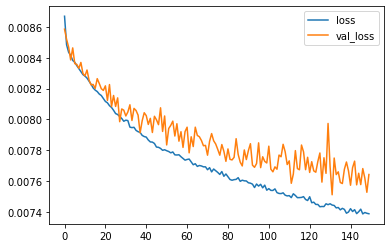

In [17]:
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history = cnn_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0, callbacks=[plot_losses])

In [18]:
dnn_model = models.Sequential()
dnn_model.add(layers.Flatten())
dnn_model.add(layers.Dense(500, activation='relu'))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.Dense(250, activation='relu'))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.Dense(100, activation='relu'))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.Dense(1))

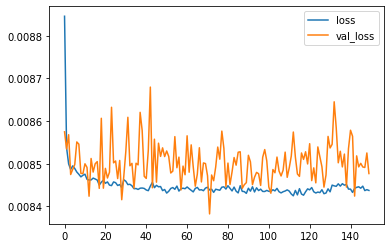

In [19]:
dnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history = dnn_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0, callbacks=[plot_losses])

In [20]:
rnn_model = models.Sequential()
rnn_model.add(layers.LSTM(32, return_sequences=True))
rnn_model.add(layers.Flatten())
rnn_model.add(layers.Dense(100, activation='relu'))
rnn_model.add(layers.Dropout(0.3))
rnn_model.add(layers.Dense(1))

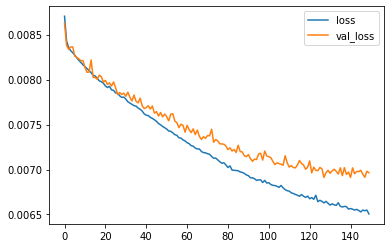

In [21]:
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history = rnn_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0, callbacks=[plot_losses])

In [22]:
dataset_test = [X_test, y_test]
dataset_test_reduced = [X_test[:10000], y_test[:10000]]

cnn_model.save('./beijing_air_multi_site_cnn_model.h5')
dnn_model.save('./beijing_air_multi_site_dnn_model.h5')
rnn_model.save('./beijing_air_multi_site_rnn_model.h5')

with open('./beijing_air_multi_site_test_data.dill', 'wb') as f:
    dill.dump(dataset_test, f)
    
with open('./beijing_air_multi_site_test_data_reduced.dill', 'wb') as f:
    dill.dump(dataset_test_reduced, f)